**классификатор текстов LSTM + W2V**

Евгений Борисов <borisov.e@solarl.ru>

https://ruscorpora.ru/new/

https://nlpub.ru/Russian_Distributional_Thesaurus    

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200  
import re
import gc
# import gzip
from tqdm import tqdm

In [2]:
tqdm.pandas()

/usr/lib/python3.9/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [4]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [5]:
neg = pd.read_csv('../data/twit/negative.csv.gz',sep=';',header=None)
ppr(neg)
neg.columns = ff

записей: 111 923


In [6]:
pos = pd.read_csv('../data/twit/positive.csv.gz',sep=';')
ppr(pos)
pos.columns = ff

записей: 114 910


In [7]:
data = pd.concat([pos,neg],sort=False)[['id','ttext', 'ttype']]
ppr(data)

записей: 226 833


In [8]:
data.sample(10)

,id,ttext,ttype
18266,411432618790772736,Сегодня еще на Волчанку звали. Сходочка любимая(( не пойду. Надо учить и готовиться морально к анальному выебу &gt;.&lt;,-1
16933,411192984076824576,"RT @mrzv_v: Алексей, не ругайте Тимошу :( http://t.co/7rWBL3oGrV",-1
57045,410120366238216192,":33333 и СССС: - это так же приторно, как и :))))) или :*****, только модно\nфу",1
90967,410849745561600000,"@yackushina миилая, а ну прекращай нюни разводить :**",1
106923,424211442754396161,Географический кретинизм( http://t.co/HMWjCKkZWf,-1
83148,410772736986730496,@nastenysh_skv @JanesRinglets Ночи тебе) Фапальных снов с:,1
63121,416883544959377408,@kennensk я не в состоянии двигаться сегодня :(,-1
97677,422814119306473472,"@NovaPauline они не увидят, и их от силы 5 :(",-1
35808,413634697487732736,"RT @cafyribex: Скажите пожалуйста, как у человека может быть 1000 одноклассников? O_o http://t.co/Y936J6xZsE",-1
98997,411060181297278976,"Сегодня ахуенный день для @eagle_ig, т.к. у него Др) ведерко с носочками оставайся таким же ведерком и не не будь ведром)",1


## очистка данных

In [9]:
data['ttext_clean'] = data['ttext']\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'^@.*',' twit ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

100%|██████████| 226833/226833 [00:02<00:00, 113398.83it/s]


In [10]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [11]:
data['ttext_clean'] = data['ttext_clean'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|██████████| 226833/226833 [00:02<00:00, 101730.55it/s]


In [12]:
data.sample(3)

,id,ttext,ttype,ttext_clean
6353,409084853007556608,"Sony Liverpool, которых не так давно закрыли Sony по непонятным причинам, открыли новую студию Firesprite и сделали для Sony Playroom. Мило)",1,"[sony, liverpool, которых, не, так, давно, закрыли, sony, по, непонятным, причинам, открыли, новую, студию, firesprite, и, сделали, для, sony, playroom, мило]"
83764,420072353901858816,"@sexmakay отлично, даже не очень холодно, но из-за полярной ночи темно, солнца нет. А завтра уже уезжаем :( как твои каникулы?",-1,"[twit, отлично, даже, не, очень, холодно, но, из, за, полярной, ночи, темно, солнца, нет, а, завтра, уже, уезжаем, sadsmile, как, твои, каникулы]"
36083,409781115801444352,ахаха Витя придумал пароль) 1488) главное не забыть),1,"[ахаха, витя, придумал, пароль, digit, главное, не, забыть]"


In [13]:
# удаление коротких слов
data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda t:[w for w in t if len(w)>2])

100%|██████████| 226833/226833 [00:00<00:00, 344335.75it/s]


In [14]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 226 833
записей: 226 831


In [15]:
data.sample(3)

,id,ttext,ttype,ttext_clean
152940,413755075874402304,"я хочу планшет,но что-то меня останавливает(",-1,"[хочу, планшет, что, меня, останавливает]"
168789,415566870402838528,@Veronika_Gera мне нет!ото плакать хочется:(,-1,"[twit, мне, нет, ото, плакать, хочется, sadsmile]"
43228,409949940308525056,@Andrey_Simon @SokolovaKatya12 @_metamfetamir @OhZenit какая? У меня вот очень прям история интересная))),1,"[twit, twit, twit, twit, какая, меня, вот, очень, прям, история, интересная, happysmile]"


In [16]:
# voc = sorted(set.union(*[ set(s) for s in data['ttext_clean'].values.tolist() ]))
# voc = { w:i+1 for i,w in enumerate(voc) }
# voc['<pad>']= 0
# ppr(voc)

## строим датасет

### кодируем word2vec

In [17]:
# %%time


# https://nlpub.ru/Russian_Distributional_Thesaurus
    
# from gensim.models import KeyedVectors 
# w2v_file = 'tenth.norm-sz500-w7-cb0-it5-min5.w2v'
# w2v = KeyedVectors.load_word2vec_format(w2v_file, binary=True, unicode_errors='ignore')
# w2v.init_sims(replace=True)

In [18]:
%%time

from gensim.models.word2vec import Word2Vec

w2v_size = 128

w2v = Word2Vec( data['ttext_clean'].values, min_count=1, size=w2v_size, window=4, workers=4)

# with open('result/Word2Vec.pkl', 'wb') as f: pickle.dump(w2v, f)

CPU times: user 57.6 s, sys: 243 ms, total: 57.9 s
Wall time: 33.1 s


In [19]:
w2v_vocab = sorted([w for w in w2v.wv.vocab])
ppr(w2v_vocab)

записей: 181 101


In [20]:
ii = np.random.permutation(len(w2v_vocab))[:30]
for i in ii:
    w = w2v_vocab[i]
    ww = [ v[0] for v in w2v.most_similar(w, topn=5) ]
    print( w,':',ww )

шаолин : ['виндзорский', 'цистит', 'битвухоров', 'остр', 'документальный']
бляяя : ['аааа', 'нуу', 'бляя', 'учебе', 'блииин']
самосовершенствоваться : ['флейк', 'дипрессия', 'протирает', 'тюн', 'разбилась']
пойдет : ['скажет', 'пойдёт', 'нами', 'думаете', 'учится']


<ipython-input-20-51489ecf273e>:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ww = [ v[0] for v in w2v.most_similar(w, topn=5) ]


расчленил : ['симпатичненько', 'kazaky', 'фалаут', 'разсткатаем', 'погорел']
закончен : ['столовке', 'халява', 'музыкалка', 'прорвало', 'гречка']
кассирши : ['форсаже', 'меньшовой', 'забылось', 'подробностях', 'гаумно']
тараса : ['чим', 'попкорном', 'результате', 'красноглазики', 'мумий']
адаптировать : ['самое', 'нелюбимое', 'долгое', 'настало', 'сложное']
поддайся : ['искушению', 'завтрашнего', 'рабочего', 'течение', 'сегодняшнего']
объясняет : ['норма', 'перезагрузи', 'трудов', 'срам', 'очевидно']
pshennaya : ['бросались', 'подрабатывали', 'мусорами', 'побисились', 'шикааааарная']
престижного : ['мартчихаж', 'яахудэ', 'набитом', 'эргүү', 'хяамарр']
стойстойстой : ['мифическая', 'пресвятому', 'силбный', 'докапались', 'романова']
рубцовск : ['делатьнечеговообще', 'нескем', 'вопросиков', 'trofolastin', 'несвободненько']
ёёёёёёёёёёёёёёёёёёёёёлки : ['хочупровестиновогоднююночьвместес', 'бармалей', 'удачиии', 'выздоравливайте', 'отдадим']
мамки : ['сойдет', 'холма', 'тайловый', 'дим', 'эм

In [21]:
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ w2v.wv.get_vector(w) for w in t ] )

100%|██████████| 226831/226831 [00:02<00:00, 94097.23it/s] 


In [22]:
%xdel w2v
%xdel w2v_vocab

In [23]:
code_max_len = data['code'].str.len().max()
code_max_len

32

In [24]:
data['code'].str.len().describe().astype(int)

count    226831
mean         10
std           3
min           1
25%           7
50%           9
75%          13
max          32
Name: code, dtype: int64

In [25]:
z = [[0.]*w2v_size]*code_max_len
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

100%|██████████| 226831/226831 [00:00<00:00, 449129.48it/s]


In [26]:
data['code'].str.len().describe().astype(int)

count    226831
mean         32
std           0
min          32
25%          32
50%          32
75%          32
max          32
Name: code, dtype: int64

In [27]:
data['code'] = data['code'].progress_apply(np.array)

100%|██████████| 226831/226831 [00:19<00:00, 11875.48it/s]


In [28]:
x = np.stack( data['code'].values )
x.shape

(226831, 32, 128)

In [29]:
x = np.flip(x,axis=1)

In [30]:
n_classes=2
target = data['ttype'].values
target = (target+1)//2
y = np.eye(n_classes)[target]

y.shape

(226831, 2)

In [31]:
%xdel data

In [32]:
gc.collect()

176

In [33]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=.4 )
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((136098, 32, 128), (136098, 2), (90733, 32, 128), (90733, 2))

In [34]:
y_train.sum(axis=0),y_test.sum(axis=0),

(array([67311., 68787.]), array([44611., 46122.]))

In [35]:
%xdel x
%xdel y

In [36]:
gc.collect()

45

## строим нейросеть 

In [37]:
seq_len = x_train.shape[1]
x_train.shape , y_train.shape, seq_len, w2v_size

((136098, 32, 128), (136098, 2), 32, 128)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [39]:
model = Sequential()
model.add(LSTM(64, input_shape=(seq_len, w2v_size)))  
model.add(Dense(n_classes, activation='softmax'))

In [40]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

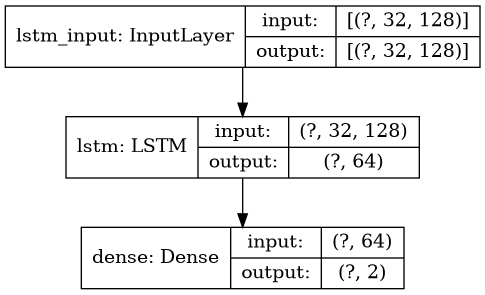

In [41]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_layer_names=True, show_shapes=True )

In [42]:
%%time

hist = model.fit(x_train,y_train, batch_size=1024, epochs=15, validation_split=.3)

Epoch 1/15
94/94 [==============================] - 2s 20ms/step - loss: 0.3913 - accuracy: 0.7960 - val_loss: 0.2601 - val_accuracy: 0.8599
Epoch 2/15
94/94 [==============================] - 1s 15ms/step - loss: 0.2468 - accuracy: 0.8663 - val_loss: 0.2706 - val_accuracy: 0.8474
Epoch 3/15
94/94 [==============================] - 1s 14ms/step - loss: 0.2360 - accuracy: 0.8708 - val_loss: 0.2319 - val_accuracy: 0.8719
Epoch 4/15
94/94 [==============================] - 1s 14ms/step - loss: 0.2270 - accuracy: 0.8762 - val_loss: 0.2623 - val_accuracy: 0.8525
Epoch 5/15
94/94 [==============================] - 1s 14ms/step - loss: 0.2278 - accuracy: 0.8750 - val_loss: 0.2323 - val_accuracy: 0.8681
Epoch 6/15
94/94 [==============================] - 1s 15ms/step - loss: 0.2212 - accuracy: 0.8777 - val_loss: 0.2334 - val_accuracy: 0.8713
Epoch 7/15
94/94 [==============================] - 1s 14ms/step - loss: 0.2187 - accuracy: 0.8816 - val_loss: 0.2552 - val_accuracy: 0.8553
Epoch 8/15
94

In [43]:
model.evaluate(x_test ,y_test )

2836/2836 [==============================] - 4s 1ms/step - loss: 0.2269 - accuracy: 0.8775


[0.22686128318309784, 0.8774867057800293]

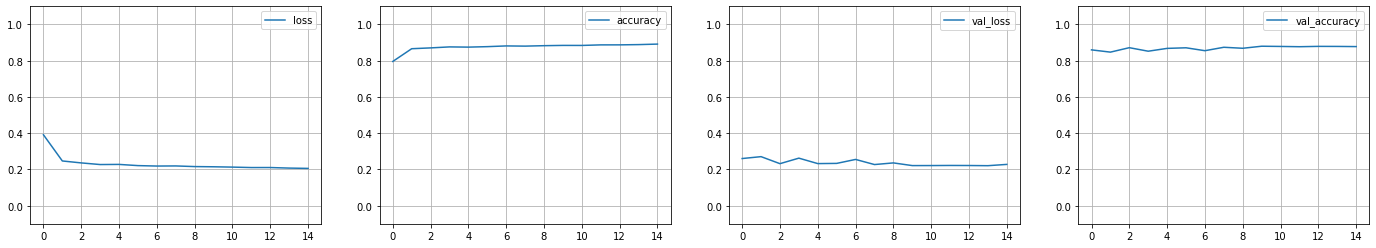

In [44]:
from matplotlib import pyplot as plt

k = hist.history.keys()

w,h = 6,4

fig,ax = plt.subplots(1,len(k),figsize=(w*len(k),h))
for i,n in enumerate(k):
    ax[i].plot(hist.history[n],label=n)
    ax[i].grid(True)
    ax[i].legend()
    ax[i].set_ylim([-.1,1.1])